In [19]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.transform import downscale_local_mean, rotate
import numpy as np
import os
import tifffile
from scipy import ndimage
import time
import torch
from torch.utils.data import Dataset, DataLoader
#import dataloader1 as dataloader
import dataloader_SRCNN as dataloader
import cv2
import skimage
import model_SRCNN

In [28]:

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of CUDA devices available: {device_count}")
    for i in range(device_count):
        device = torch.cuda.get_device_name(i)
        print(f"Device {i}: {device}")
else:
    print("CUDA is not available on this machine.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Number of CUDA devices available: 1
Device 0: Quadro RTX 4000


In [29]:
patch_size = 64
batch_size = 1

In [30]:
# Set the paths to data and target files
train_files = [
    ('01_Substack (7882-8277)_B45_bag5_.tif','registered_image01_3dCT_B45_bag5_100mm.tif'),
    #('02_Substack (6267-6662)_B40_bag12_13.tif','registered_image02_3dCT_B40_bag12_13_300mm.tif' ),
    ('03_Substack (6241-6635)_B40_bag22_23.tif', 'registered_image03_3dCT_B40_bag22_23_300mmLUT.tif' ),
    ('04_Substack (7285-7546)_B40_bag32_33.tif','registered_image04_3dCT_B40_bag32_33_200mm_Substack(396-1440).tif' ),
    ('05_Substack (6292-6686)_B40_bag46_47.tif','registered_image05_3dCT_B40_bag46_47_300mm.tif'),
    #('06_Substack (8055-8449)_B40_bag56_57.tif','registered_image06_3dCT_B40_bag56_57_100mm.tif' ),
    ('07_Substack (5525-5920)_B40_bag66_67.tif', 'registered_image07_3dCT_B40_bag66_67_400mm.tif' ),
    ('08_Substack (3424-3818)_B40_bag86_87.tif', 'registered_image08_3dCT_B40_bag86_87_640mm.tif' ),
    ('09_Substack (3098-3490)_B40_bag96_97.tif', 'registered_image09_3dCT_B40_bag96_97_675mm.tif' ),
    #('10_Substack (4268-4663)_B40_bag108_109.tif','registered_image10_3dCT_B40_bag108_109_538mm.tif'),
    ('11_Substack (305-698)_B40_bag126_127.tif', 'registered_image11_3dCT_B40_bag126_127_1002mm.tif')
    ]

test_files = [
    #('01_Substack (7882-8277)_B45_bag5_.tif','registered_image01_3dCT_B45_bag5_100mm.tif'),
    ('02_Substack (6267-6662)_B40_bag12_13.tif','registered_image02_3dCT_B40_bag12_13_300mm.tif' ),
    #('03_Substack (6241-6635)_B40_bag22_23.tif', 'registered_image03_3dCT_B40_bag22_23_300mmLUT.tif' ),
    #('04_Substack (7285-7546)_B40_bag32_33.tif','registered_image04_3dCT_B40_bag32_33_200mm_Substack(396-1440).tif' ),
    #('05_Substack (6292-6686)_B40_bag46_47.tif','registered_image05_3dCT_B40_bag46_47_300mm.tif'),
    ('06_Substack (8055-8449)_B40_bag56_57.tif','registered_image06_3dCT_B40_bag56_57_100mm.tif' ),
    #('07_Substack (5525-5920)_B40_bag66_67.tif', 'registered_image07_3dCT_B40_bag66_67_400mm.tif' ),
    #('08_Substack (3424-3818)_B40_bag86_87.tif', 'registered_image08_3dCT_B40_bag86_87_640mm.tif' ),
    #('09_Substack (3098-3490)_B40_bag96_97.tif', 'registered_image09_3dCT_B40_bag96_97_675mm.tif' ),
    ('10_Substack (4268-4663)_B40_bag108_109.tif','registered_image10_3dCT_B40_bag108_109_538mm.tif'),
    #('11_Substack (305-698)_B40_bag126_127.tif', 'registered_image11_3dCT_B40_bag126_127_1002mm.tif')
    ]

In [31]:

# If need to generate pathes for the firs time then put true for the need_patches
test_dataset = dataloader.microCT_Dataset(test_files,train_or_test = 'test',
                                         HR_patch_size=patch_size,
                                         transform = None,
                                          need_patches=False)
test_data_loader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              shuffle=True)

In [32]:
# Create an iterator for the DataLoader
data_iter = iter(test_data_loader)


In [53]:
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    
model = model_SRCNN.SRCNN()
load_checkpoint(torch.load("my_SRCNN_checkpoint.pth.tar"), model)


=> Loading checkpoint


Input Data Shape: torch.Size([1, 1, 64, 64, 64])
Target Shape: torch.Size([1, 1, 64, 64, 64])
prediction shape =  (1, 1, 64, 64, 64)


Text(0.5, 1.0, 'Super-Resolution')

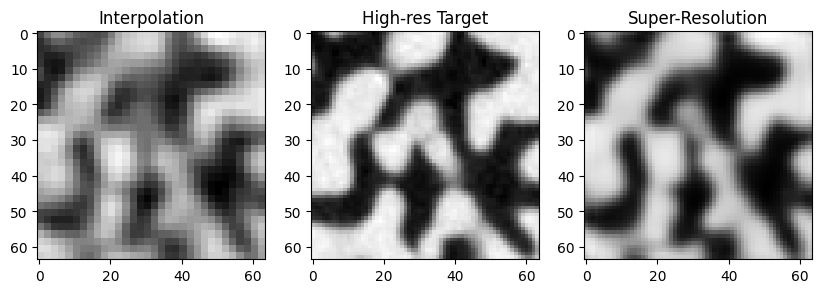

In [48]:
# Get one batch (one sample) from the iterator
sample_batch = next(data_iter)

# Extract input and target from the sample batch
input_data, target = sample_batch

# Now, you have one sample of input data and its corresponding target
print("Input Data Shape:", input_data.shape)
print("Target Shape:", target.shape)

# prediction
data = input_data.to(device)
prediction = model(input_data)
prediction = prediction.cpu().detach().numpy()
print ('prediction shape = ', prediction.shape)


input_image = input_data[0,0,0,:,:]
target_image = target[0,0,0,:,:]
prediction_image = prediction[0,0,0,:,:]


# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot input image
axes[0].imshow(input_image, cmap='gray') 
axes[0].set_title('Interpolation')
#axes[0].axis('off')

# Plot target image
axes[1].imshow(target_image, cmap='gray')  # Assuming target is grayscale
axes[1].set_title('High-res Target')
#axes[1].axis('off')

axes[2].imshow(prediction_image, cmap='gray')
axes[2].set_title('Super-Resolution')



C:\Users\Fabagh001\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


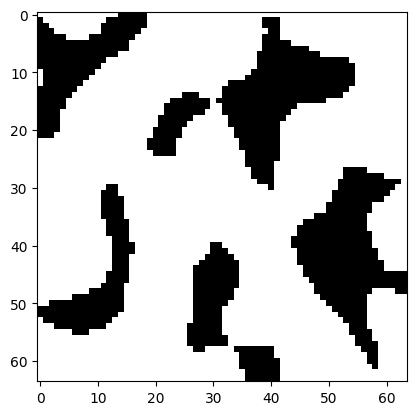

In [52]:

def binary_segmentation_kmean(image, k=2):

    # Flatten the image to a 1D array
    flat_image = image.flatten()

    # Reshape to a column vector
    flat_image = flat_image.reshape(-1, 1)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(flat_image)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Assign pixels based on cluster centers
    segmented_image = np.where(image >= centers[1], 1, 0)

    return segmented_image

segmented_image = binary_segmentation(prediction_image)

plt.imshow(segmented_image, 'gray')
